## Кубические сплайны

$\textbf{Кубический сплайн}$ (дефекта 1), интерполирующий $f(x)$ на $[a, b]$: $$c(x) := d_k + c_k (x-x_k) + b_k (x-x_k)^2 + a_k (x-x_k)^3,$$ 

где $x\in [x_{k-1}, x_{k}] \big|_{k=1}^n$

$\textbf{Обозначение кубического сплайна дефекта 1}$: $S^n_{3,2}$, где $n, 3, 2$ - кол-во узлов интерполирования, старшая степень и порядок гладкости сплайна соответственно.

$\textbf{Краевые условия}$: 
$$ \textbf{1)}\; c(x_k) = f(x_k), \;\; \textbf{2)}\; c(x) \in C^2([a,b]), \;\; \textbf{3)}\; c''(a) = c''(b)=0$$
При выполнении условия $\textbf{3)}$ сплайн называется $\textbf{естественным}$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import json

In [2]:
with open("cfg.json", "r") as f:
    cfg = json.load(f)

In [3]:
# Исходная функция
def fn(x):
    return x**2 + 4*np.sin(x) - 2

Text(0.5, 1.0, 'Интерполируемая функция')

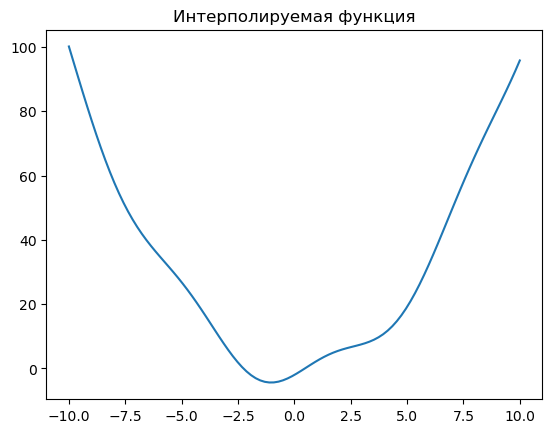

In [4]:
xarr = np.linspace(cfg['params']['a'],
                        cfg['params']['b'],
                        cfg['params']['m'])
plt.plot(xarr, fn(xarr))
plt.title(f'Интерполируемая функция')

## Кубический сплайн

In [5]:
class cubic_spline():
    def __init__(self, a, b, m, node_type: str='equal') -> None:
        self.a = a # leftmost point of the interval
        self.b = b # rightmost point of the interval
        self.m = m # num of nodes
        self.n = self.m - 1 # num of cubic splines
        assert node_type in ['optimal', 'equal'], 'Incorrect node type. Choose from [optimal, equal]'
        self.node_type = node_type
        self.x = self.get_nodes()
        self.coeffs = self.get_coeffs()

    def get_nodes(self):
        # choose interpolation interval
        if self.node_type == 'optimal':
            # optimal chebyshev nodes
            interval = sorted([0.5 * ((self.b - self.a) * np.cos(((2*i+1)*np.pi) / (2*(self.m + 1))) + (self.b + self.a)) for i in range(self.m)])
        elif self.node_type == 'equal':
            # equally-spaced nodes
            interval = np.linspace(self.a, self.b, self.m) 
        return interval

    def get_coeffs(self):
        n = self.n
        A = np.zeros((4*n, 4*n))
        C = np.zeros(4*n)

        # создаем матрицу системы
        A, C = self.make_system(A, C)

        # Решаем относительно b
        B = np.linalg.solve(A, C)

        ai = B[:n]
        bi = B[n:2*n]
        ci = B[2*n:3*n]
        di = B[3*n:]

        return ai, bi, ci, di
        
    def make_system(self, A, C):
        x = self.x
        n = self.n
        for i in range(n):
            A[i, i] = x[i]**3
            A[i, n+i] = x[i]**2
            A[i, 2*n+i] = x[i]
            A[i, 3*n+i] = 1

            # Строки [n, 2n-1]
            A[n+i, i] = x[i+1]**3
            A[n+i, n+i] = x[i+1]**2
            A[n+i, 2*n+i] = x[i+1]
            A[n+i, 3*n+i] = 1

            C[i] = fn(x[i])
            C[n+i] = fn(x[i+1])

        # Строки [2n, 3n-1]
        for j in range(n-1):
            row = 2*n+j
            columns = [j, j+1, n+j, n+j+1, 2*n+j, 2*n+j+1]

            # start at j+1 since derivatives are equal at the interior points
            values = 3*x[j+1]**2, -3*x[j+1]**2, 2*x[j+1], -2*x[j+1], 1, -1
            A[row, [columns]] = values

            # Значения функции для рядов C из промежутка [2n: 3n-1] равны нулю, 
            # поскольку мы приравниваем производные

        # Строки [3n-1, 4n-2]
        for q in range(n-1):
            row = 3*n-1 + q
            columns = [q, q+1, n+q, n+q+1]
            values = 6*x[q+1], -6*x[q+1], 2, -2
            A[row, [columns]] = values

            # Значения функции для рядов C из промежутка [3n-1: 4n-2] равны нулю, 
            # поскольку мы приравниваем производные

        # Задаем вторые производные на граничны точках (x0, xn) равными нулю, 
        # чтобы получить два дополнительных уравнения - естественный сплайн
        A[4*n-2, [0, n]] = 6*x[0], 2
        A[4*n-1, [n-1, 2*n-1]] =  6*x[n], 2

        return A, C

    def __call__(self, arg):
        assert (arg >= self.x[0]) and (arg <= self.x[-1]),\
            f'Argument ({arg}) out of interval bounds [{self.x[0]:.3f}, {self.x[-1]:.3f}]!'
        
        # Вычисление значения от кубического сплайна    
        ai, bi, ci, di = self.coeffs

        # Find the index where arg would fit in the array x
        idx = np.searchsorted(self.x, arg) - 1
        
        # Ensure idx is within bounds
        idx = min(max(idx, 0), len(self.x) - 2)

        res = ai[idx]*arg**3 + bi[idx]*arg**2 + ci[idx]*arg + di[idx]
        return res

    def plot_spline(self):   
        ai, bi, ci, di = self.coeffs
        for k in range(self.n):
            xspline = np.linspace(self.x[k], self.x[k+1])
            yspline = ai[k]*xspline**3 + bi[k]*xspline**2 + ci[k]*xspline + di[k]    
            plt.plot(xspline, yspline, '-', linewidth=4)

        plt.plot(xarr, fn(xarr), color='black', linestyle='--', label='Ground truth')
        plt.xlabel('x')
        plt.ylabel('y')
        if self.node_type == 'equal':
            plt.title('$S_{3,2}^m$ по равноотстоящим узлам для $f(x)$')
        else:
            plt.title('$S_{3,2}^m$ по узлам Чебышева для $f(x)$')
        plt.legend()
        plt.show()

In [25]:
spline = cubic_spline(-10, 10, 6)


In [26]:
spline(10)

95.82391555644254

## Изобразим $S_{3,2}^{m}$

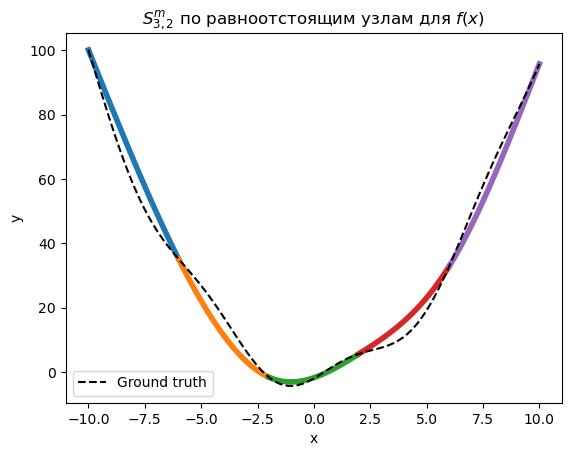

In [27]:
spline.plot_spline()

## Кубические сплайны по оптимальным узлам Чебышева 
$$x_i = 0.5 \left((b-a)\cos\dfrac{(2i+1)\pi}{2(n+1)} + (b+a)\right),\; i\in \overline{0,n}$$

In [28]:
opt_spline = cubic_spline(a=-10, b=10, m=6, node_type='optimal')

In [30]:
opt_spline(9.7)

91.05798428599104

## Изобразим $S_{3,2}^{m_{opt}}$

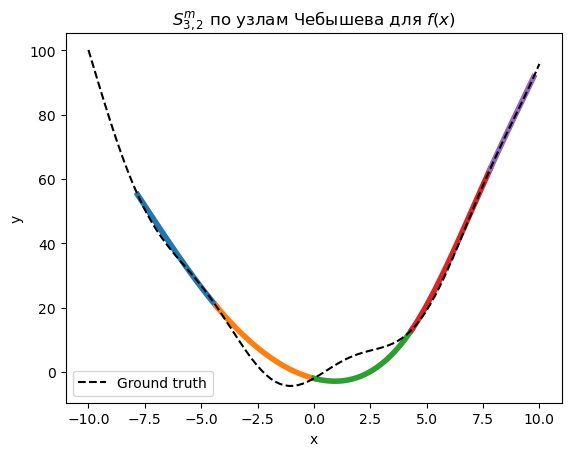

In [31]:
opt_spline.plot_spline()

## Найдем максимальные отклонения $RS_{3,2}^n, RS_{3,2}^{n_{opt}}$

In [12]:
# количество k точек разбиения интервала интерполирования, в которых определяются отклонения
k = cfg['params']['k']
max_nodes = cfg['params']['max_nodes']
a = cfg['params']['a']
b = cfg['params']['b']

In [48]:
from utils import get_deviations

In [14]:
r1, r2, nodes = get_deviations(cubic_spline, a, b, k, max_nodes)

In [15]:
df = pd.DataFrame({
    'num of nodes': nodes,
    'RSn_max': r1,
    'RSn_opt_max': r2,
})
df

,num of nodes,RSn_max,RSn_opt_max
0,3,11.873489,84.999983
1,4,9.278315,66.049636
2,5,8.682818,55.011530
3,6,7.041229,45.047494
4,7,4.751355,36.624853
5,8,1.605393,29.944858
6,9,1.239068,24.755961
7,10,0.728252,20.723383


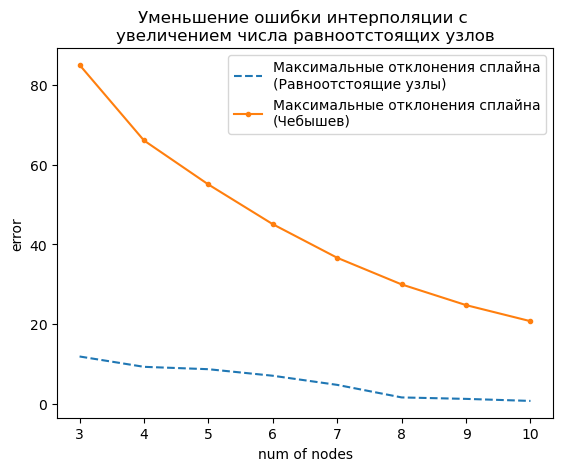

In [16]:
plt.plot(df['num of nodes'], df['RSn_max'], '--', label='Максимальные отклонения сплайна\n(Равноотстоящие узлы)')
plt.plot(df['num of nodes'], df['RSn_opt_max'], '.-', label='Максимальные отклонения сплайна\n(Чебышев)')
plt.title(f'Уменьшение ошибки интерполяции с \nувеличением числа равноотстоящих узлов')
plt.xlabel(f'num of nodes')
plt.ylabel(f'error')
plt.legend()
plt.show()

## Графики распределения абсолютной погрешности на $[a,b]$ при некоторых $n$

## $N_n$

In [17]:
from sympy import sin, cancel, Symbol, cos

In [18]:
class Newton():
    def __init__(self, a, b, k, node_type: str='equal') -> None:
        self.a = a
        self.b = b
        self.k = k
        assert node_type in ['optimal', 'equal'], 'Incorrect node type. Choose from [optimal, equal]'
        self.node_type = node_type
        self.nodes = self.get_nodes()
        self.func_val = [self.fun(i) for i in self.nodes]
        self.poly = self.newton_polynomial()

    def get_nodes(self):
        if self.node_type == 'optimal':
            interval = [0.5 * ((self.b-self.a)*cos(((2*i+1)*np.pi)/(2*(self.k+1))) + (self.b+self.a)) for i in range(self.k)]
        else:
            interval = np.linspace(self.a, self.b, self.k)
        return interval

    def fun(self, x):
        x = Symbol('x')
        return x**2 + 4*sin(x) - 2
    
    def divided_differences(self, k):
        # посчитать f(x0; ...; xk) - разделенные разности
        f_x0_to_xk, prod = 0, 1
        for j in range(0, k + 1):
            for i in range(0, k + 1):
                if i != j:
                    prod *= (self.nodes[j] - self.nodes[i])
            f_x0_to_xk += self.func_val[j] / prod
            prod = 1
        return f_x0_to_xk
    
    def newton_polynomial(self):
        # вычисляем полином Ньютона, N_k
        x = Symbol('x')
        product = 1
        newton = self.divided_differences(0)
        for i in range(1, self.k):
            product *= (x - self.nodes[i-1])
            newton += self.divided_differences(i) * product
        return cancel(newton)
    
    def __call__(self, arg):
        x = Symbol('x')
        return self.poly.subs(x, arg)

In [19]:
newt = Newton(a, b, k)

## $N_{n_{opt}}$


In [20]:
newt_opt = Newton(a, b, k, 'optimal')

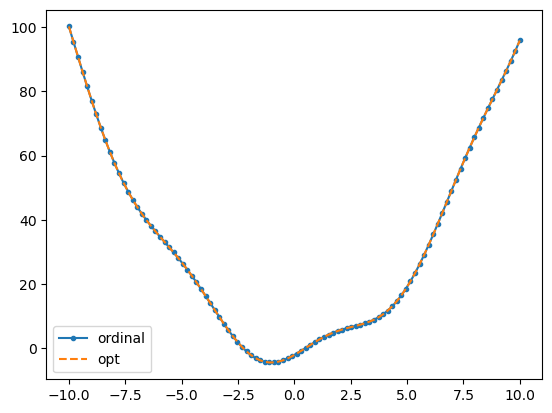

In [21]:
plt.plot(xarr, [newt_opt(i) for i in xarr], '.-', label='ordinal')
plt.plot(xarr, [newt(i) for i in xarr], '--', label='opt')
plt.legend()

In [49]:
r1, r2, nodes = get_deviations(Newton, a, b, k, max_nodes)

In [50]:
df = pd.DataFrame({
    'num of nodes': nodes,
    'RSn_max': r1,
    'RSn_opt_max': r2,
})
df

,num of nodes,RSn_max,RSn_opt_max
0,3,0,88.0137842893800
1,4,5.68434188608080e-14,92.0269176315355
2,5,7.10542735760100e-14,94.2907160063751
3,6,2.70006239588838e-13,95.6918952898639
4,7,8.81072992342524e-13,96.6176757659251
5,8,2.67164068645798e-12,97.2603429054441
6,9,8.88178419700125e-12,97.7241801511358
7,10,2.86348722511320e-11,98.0696548907177


Увеличение ошибки интерполяции с увеличением числа равноотстоящих узлов. Происходит потому, что степеней свободы становится слишком много с увеличением кол-ва слагаемых, либо потому что такова специфика многочленов Ньютона - хз. С преподом так и не поняли причину

Text(0, 0.5, 'error')

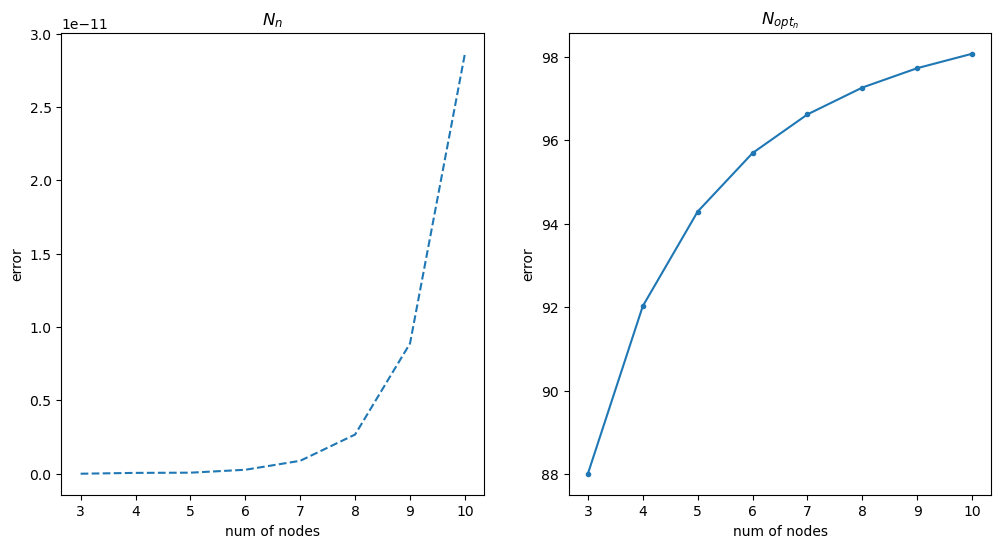

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(df['num of nodes'], df['RSn_max'], '--', label='Максимальные отклонения сплайна\n(Равноотстоящие узлы)')
ax[0].set_xlabel(f'num of nodes')
ax[0].set_ylabel(f'error')
ax[0].set_title('$N_n$')

ax[1].plot(df['num of nodes'], df['RSn_opt_max'], '.-', label='Максимальные отклонения сплайна\n(Чебышев)')
ax[1].set_title('$N_{opt_n}$')
ax[1].set_xlabel(f'num of nodes')
ax[1].set_ylabel(f'error')